# **DESCARGA DATASET**


In [5]:
!rm -rf /root/sound_datasets/urbansound8k


In [6]:
!pip install soundata pandas librosa --quiet

import soundata
import os
import shutil
import pandas as pd

# 1. Inicializa y descarga el dataset
dataset = soundata.initialize('urbansound8k')
dataset.download()

# 2. Verifica ruta real de descarga
print("Ruta base del dataset descargado:", dataset.data_home)

# 3. Busca el CSV
metadata_path = os.path.join(dataset.data_home, 'UrbanSound8K.csv')

# ⚠️ Si no existe, intentar ubicar manualmente
if not os.path.exists(metadata_path):
    # Buscar en subcarpetas
    for root, dirs, files in os.walk(dataset.data_home):
        for file in files:
            if file == 'UrbanSound8K.csv':
                metadata_path = os.path.join(root, file)
                break

print("Ruta real del CSV:", metadata_path)

# 4. Cargar metadata
metadata = pd.read_csv(metadata_path)

# 5. Filtrar sonidos de disparos
gunshots = metadata[metadata['class'] == 'gun_shot']

# 6. Crear carpeta para audios de disparo
output_folder = 'gunshot_only'
os.makedirs(output_folder, exist_ok=True)

# 7. Copiar audios
for _, row in gunshots.iterrows():
    fold = row['fold']
    fname = row['slice_file_name']
    src = os.path.join(dataset.data_home, 'audio', f'fold{fold}', fname)
    if os.path.exists(src):
        shutil.copy(src, os.path.join(output_folder, fname))

print(f"Se copiaron {len(os.listdir(output_folder))} archivos de disparos.")


5.61GB [30:04, 3.34MB/s]                            
1.15MB [00:02, 488kB/s]                            


Ruta base del dataset descargado: /root/sound_datasets/urbansound8k
Ruta real del CSV: /root/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv
Se copiaron 374 archivos de disparos.


DATASET POSITIVO AUDIOS

In [10]:
import os

os.makedirs("no_disparo_fixed", exist_ok=True)

for file in os.listdir("no_disparo"):
    if file.endswith(".wav"):
        input_path = f"no_disparo/{file}"
        output_path = f"no_disparo_fixed/{file}"
        !ffmpeg -y -i "$input_path" -ac 1 -ar 16000 -vn "$output_path"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [11]:
!mkdir -p no_disparo

!wget -q -O no_disparo/1.wav https://github.com/marcogdepinto/Sound-Classification/raw/main/audio_samples/ambient.wav
!wget -q -O no_disparo/2.wav https://github.com/marcogdepinto/Sound-Classification/raw/main/audio_samples/airplane.wav
!wget -q -O no_disparo/3.wav https://github.com/marcogdepinto/Sound-Classification/raw/main/audio_samples/people_talking.wav
!wget -q -O no_disparo/4.wav https://github.com/marcogdepinto/Sound-Classification/raw/main/audio_samples/train.wav
!wget -q -O no_disparo/5.wav https://github.com/marcogdepinto/Sound-Classification/raw/main/audio_samples/street_noise.wav

metadata = pd.read_csv("/root/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv")

import os
print(f"Total de audios negativos descargados: {len(os.listdir('no_disparo'))}")

# Filtrar clases NO relacionadas a disparos
non_gunshot = metadata[metadata['class'] != 'gun_shot']

# Selecciona 100 ejemplos aleatorios de otras clases
non_gunshot_sample = non_gunshot.sample(n=100, random_state=42)

# Cópialos a 'no_disparo'
for _, row in non_gunshot_sample.iterrows():
    fold = row['fold']
    fname = row['slice_file_name']
    src = os.path.join(dataset.data_home, 'audio', f'fold{fold}', fname)
    if os.path.exists(src):
        shutil.copy(src, os.path.join('no_disparo', fname))


Total de audios negativos descargados: 105


EXTRACCIÓN DE CARACTERISTICAS

In [12]:
import librosa
import numpy as np
import os

def extract_features_from_folder(folder_path, label, n_mfcc=40):
    features, labels = [], []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            try:
                audio, sr = librosa.load(os.path.join(folder_path, file), sr=16000)

                # MFCC
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                mfcc_mean = np.mean(mfcc.T, axis=0)

                # Otros features
                zcr = librosa.feature.zero_crossing_rate(y=audio)[0].mean()
                rms = librosa.feature.rms(y=audio)[0].mean()
                spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0].mean()

                # Concatenar todo en un solo vector
                feature_vector = np.hstack([mfcc_mean, zcr, rms, spectral_centroid])
                features.append(feature_vector)
                labels.append(label)

            except Exception as e:
                print(f"⚠️ Error con archivo {file}: {e}")
                continue

    return features, labels

# Disparos = 1
X1, y1 = extract_features_from_folder('gunshot_only', 1)

# No disparos = 0
X0, y0 = extract_features_from_folder('no_disparo', 0)

# Dataset final
X = np.array(X1 + X0)
y = np.array(y1 + y0)


/tmp/ipython-input-12-1135671003.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(os.path.join(folder_path, file), sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


⚠️ Error con archivo 2.wav: 
⚠️ Error con archivo 1.wav: 
⚠️ Error con archivo 5.wav: 
⚠️ Error con archivo 4.wav: 
⚠️ Error con archivo 3.wav: 


ENTRENAR MODELO

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ⚠️ Si X está en forma (samples, features), debes expandir una dimensión
X_reshaped = np.expand_dims(X, axis=-1)  # ahora es (samples, features, 1)

# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# 2. One-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# 3. Definir modelo
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Entrenar
model.fit(X_train, y_train_cat, epochs=40, batch_size=8, validation_data=(X_test, y_test_cat))

# 5. Evaluar
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 6. Reporte de clasificación
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.7602 - loss: 0.7575 - val_accuracy: 0.7368 - val_loss: 0.4812
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8723 - loss: 0.3167 - val_accuracy: 0.8737 - val_loss: 0.3740
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8775 - loss: 0.3323 - val_accuracy: 0.9263 - val_loss: 0.3044
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8887 - loss: 0.3154 - val_accuracy: 0.9053 - val_loss: 0.2850
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8768 - loss: 0.2922 - val_accuracy: 0.9053 - val_loss: 0.2756
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8740 - loss: 0.2643 - val_accuracy: 0.9263 - val_loss: 0.2200
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8677 - loss: 0.2428 - val_accuracy: 0.9158 - val_loss: 0.1971
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9028 - loss: 0.2438 - val_accuracy: 0.9053 - val_los

GUARDAR MODELO

In [14]:
model.save('detector_disparos.h5')
print("Modelo guardado como detector_disparos.h5")

Modelo guardado como detector_disparos.h5


PRUEBAS

🔼 Sube tu audio en formato .wav (16kHz, mono recomendado):


Saving risas.wav to risas (2).wav
📂 Audio cargado: risas (2).wav


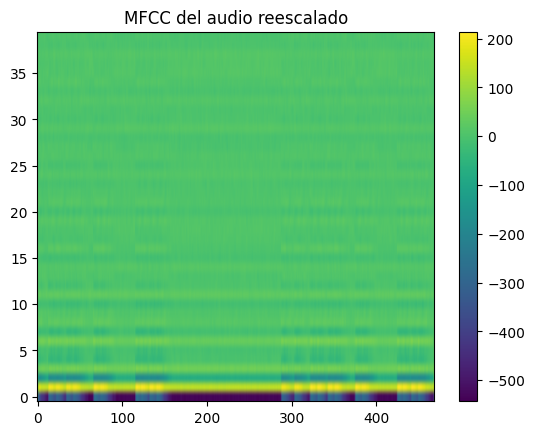

📦 Total fragmentos generados: 2
🔁 Cargando modelo detector de disparos...
🎙️ Analizando fragmentos...
✔️ Limpio: audio_chunks/chunk_0.wav (6.1%)
✔️ Limpio: audio_chunks/chunk_1.wav (2.7%)


In [26]:
# 🔧 INSTALACIONES (solo la primera vez)
!pip install librosa soundfile --quiet

# 📁 IMPORTS
import os
import numpy as np
import librosa
import soundfile as sf
from google.colab import files
from tensorflow.keras.models import load_model

# 🔼 SUBIR AUDIO WAV
print("🔼 Sube tu audio en formato .wav (16kHz, mono recomendado):")
uploaded = files.upload()

# 🧩 PROCESAR AUDIO SUBIDO
for fname in uploaded.keys():
    audio_path = fname
    print(f"📂 Audio cargado: {audio_path}")

    # Crear carpeta de fragmentos
    os.makedirs("audio_chunks", exist_ok=True)

    # Cargar y dividir audio
    y, sr = librosa.load(audio_path, sr=16000)
    chunk_duration = 2 * sr  # 2 segundos
    chunk_paths = []

    mfcc = librosa.feature.mfcc(y=y_resampled, sr=16000, n_mfcc=40)
    plt.imshow(mfcc, aspect='auto', origin='lower')
    plt.title("MFCC del audio reescalado")
    plt.colorbar()
    plt.show()


    for i in range(0, len(y), chunk_duration):
        chunk = y[i:i+chunk_duration]
        if len(chunk) < chunk_duration:
            break
        chunk_file = f"audio_chunks/chunk_{i//chunk_duration}.wav"
        sf.write(chunk_file, chunk, sr)
        chunk_paths.append(chunk_file)

    print(f"📦 Total fragmentos generados: {len(chunk_paths)}")

    # Cargar modelo
    print("🔁 Cargando modelo detector de disparos...")
    model = load_model("detector_disparos.h5")

    # Función de predicción
    def predict_chunk(path, n_mfcc=40):
      audio, sr = librosa.load(path, sr=16000)

    # MFCC
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
      mfcc_mean = np.mean(mfcc.T, axis=0)

    # Otros features
      zcr = librosa.feature.zero_crossing_rate(y=audio)[0].mean()
      rms = librosa.feature.rms(y=audio)[0].mean()
      spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0].mean()

    # Concatenar en el mismo orden que entrenaste
      feature_vector = np.hstack([mfcc_mean, zcr, rms, spectral_centroid])  # 43 dimensiones

    # Darle forma (1, 43, 1)
      input_tensor = feature_vector.reshape(1, -1, 1)

    # Predicción
      prediction = model.predict(input_tensor, verbose=0)
      return prediction[0][1]  # probabilidad de "disparo"

    # Análisis por fragmento
    print("🎙️ Analizando fragmentos...")
    for path in chunk_paths:
      prob = predict_chunk(path)
      if prob > 0.65:
          print(f"🚨 Disparo detectado en {path} ({prob*100:.1f}%)")
      else:
          print(f"✔️ Limpio: {path} ({prob*100:.1f}%)")


In [21]:
!md5sum detector_disparos.h5


9fb944bee6290512c8a545c2bfc7036c  detector_disparos.h5
